In [1]:
import numpy as np
import pandas as pd
import torch
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from nltk import pos_tag, word_tokenize
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from sentence_transformers import SentenceTransformer
from transformers import T5EncoderModel, T5Tokenizer, CLIPTokenizer, CLIPTextModel
from sklearn.preprocessing import StandardScaler

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Make sure you have downloaded the necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("Loading data...")

Loading data...


In [3]:
# Load the data
stimuli = [line.strip() for line in open('data/stimuli.txt').readlines()]
subj1 = np.load('data/subj1.npy', allow_pickle=True).item()
subj2 = np.load('data/subj2.npy', allow_pickle=True).item()
subjects = {'subj1': subj1, 'subj2': subj2}
ROIs = ['language', 'vision', 'task', 'dmn']

print(f"Number of stimuli: {len(stimuli)}")
print(f"Number of ROIs in Subject 1: {len(subj1.keys())}")
print(f"Number of ROIs in Subject 2: {len(subj2.keys())}")
print(f"ROIs: {list(subj1.keys())}")

Number of stimuli: 627
Number of ROIs in Subject 1: 4
Number of ROIs in Subject 2: 4
ROIs: ['language', 'vision', 'dmn', 'task']


In [4]:
# Function to generate sentence embeddings
def generate_embeddings():
    print("Generating sentence embeddings...")
    
    # SBERT Models
    sbert_model1 = SentenceTransformer('all-MiniLM-L6-v2')
    sbert_model2 = SentenceTransformer('all-mpnet-base-v2')
    
    # T5 Model
    t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
    t5_model = T5EncoderModel.from_pretrained('t5-small')
    
    # CLIP Model
    clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    clip_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
    
    # Generate SBERT embeddings
    print("Generating SBERT embeddings...")
    sbert1_embeddings = sbert_model1.encode(stimuli, show_progress_bar=True)
    sbert2_embeddings = sbert_model2.encode(stimuli, show_progress_bar=True)
    
    # Generate T5 embeddings
    print("Generating T5 embeddings...")
    t5_embeddings = []
    batch_size = 32
    for i in tqdm(range(0, len(stimuli), batch_size)):
        batch = stimuli[i:min(i+batch_size, len(stimuli))]
        inputs = t5_tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = t5_model(**inputs)
            # Average the hidden states
            embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
            t5_embeddings.append(embeddings)
    t5_embeddings = np.vstack(t5_embeddings)
    
    # Generate CLIP embeddings
    print("Generating CLIP embeddings...")
    clip_embeddings = []
    for i in tqdm(range(0, len(stimuli), batch_size)):
        batch = stimuli[i:min(i+batch_size, len(stimuli))]
        inputs = clip_tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = clip_model(**inputs)
            # Average the hidden states
            embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
            clip_embeddings.append(embeddings)
    clip_embeddings = np.vstack(clip_embeddings)
    
    # Print the shapes of the embeddings
    print(f"SBERT1 embeddings shape: {sbert1_embeddings.shape}")
    print(f"SBERT2 embeddings shape: {sbert2_embeddings.shape}")
    print(f"T5 embeddings shape: {t5_embeddings.shape}")
    print(f"CLIP embeddings shape: {clip_embeddings.shape}")
    
    # Return all embeddings
    return {
        'SBERT1': sbert1_embeddings,
        'SBERT2': sbert2_embeddings,
        'T5': t5_embeddings,
        'CLIP': clip_embeddings
    }

# Generate embeddings
embeddings = generate_embeddings()

Generating sentence embeddings...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Generating SBERT embeddings...


Batches: 100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Generating T5 embeddings...


100%|██████████| 20/20 [00:01<00:00, 19.08it/s]


Generating CLIP embeddings...


100%|██████████| 20/20 [00:01<00:00, 10.83it/s]

SBERT1 embeddings shape: (627, 384)
SBERT2 embeddings shape: (627, 768)
T5 embeddings shape: (627, 512)
CLIP embeddings shape: (627, 512)


In [5]:
def cosine_distance(u, v):
    """Compute the cosine distance between two vectors."""
    return 1 - cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0][0]

def compute_2v2_accuracy(Y_true, Y_pred):
    """
    Compute the 2V2 accuracy as described in the assignment.
    
    Args:
        Y_true: True sentence embeddings (N x D)
        Y_pred: Predicted sentence embeddings (N x D)
        
    Returns:
        2V2 accuracy score
    """
    N = Y_true.shape[0]
    correct = 0
    total = 0
    
    for i in range(N-1):
        for j in range(i+1, N):
            # True pairs
            cos_ii = cosine_similarity(Y_true[i:i+1], Y_pred[i:i+1])[0][0]
            cos_jj = cosine_similarity(Y_true[j:j+1], Y_pred[j:j+1])[0][0]
            
            # Swapped pairs
            cos_ij = cosine_similarity(Y_true[i:i+1], Y_pred[j:j+1])[0][0]
            cos_ji = cosine_similarity(Y_true[j:j+1], Y_pred[i:i+1])[0][0]
            
            # Check if true pairs have higher similarity than swapped pairs
            if (cos_ii + cos_jj) > (cos_ij + cos_ji):
                correct += 1
            total += 1
    
    return correct / total

def compute_pearson_correlation(Y_true, Y_pred):
    """
    Compute the average Pearson correlation across samples.
    
    Args:
        Y_true: True sentence embeddings (N x D)
        Y_pred: Predicted sentence embeddings (N x D)
        
    Returns:
        Average Pearson correlation
    """
    correlations = []
    for i in range(Y_true.shape[0]):
        r, _ = pearsonr(Y_true[i], Y_pred[i])
        correlations.append(r)
    
    return np.mean(correlations)

def compute_rank_accuracy(Y_true, Y_pred):
    """
    Compute the median rank of true sentences among all predictions.
    
    Args:
        Y_true: True sentence embeddings (N x D)
        Y_pred: Predicted sentence embeddings (N x D)
        
    Returns:
        Median rank
    """
    N = Y_true.shape[0]
    ranks = []
    
    for i in range(N):
        # Compute similarities between the prediction and all true embeddings
        similarities = []
        for j in range(N):
            similarity = cosine_similarity(Y_pred[i:i+1], Y_true[j:j+1])[0][0]
            similarities.append((j, similarity))
        
        # Sort by similarity in descending order
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        # Find the rank of the true sentence
        for rank, (idx, _) in enumerate(similarities):
            if idx == i:
                ranks.append(rank + 1)  # +1 because ranks start from 1
                break
    
    return np.median(ranks)

def compute_topk_accuracy(Y_true, Y_pred, k=5):
    """
    Compute the top-k accuracy.
    
    Args:
        Y_true: True sentence embeddings (N x D)
        Y_pred: Predicted sentence embeddings (N x D)
        k: Number of top predictions to consider
        
    Returns:
        Top-k accuracy
    """
    N = Y_true.shape[0]
    correct = 0
    
    for i in range(N):
        # Compute similarities between the prediction and all true embeddings
        similarities = []
        for j in range(N):
            similarity = cosine_similarity(Y_pred[i:i+1], Y_true[j:j+1])[0][0]
            similarities.append((j, similarity))
        
        # Sort by similarity in descending order
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        # Check if true sentence is in top k
        top_k_indices = [idx for idx, _ in similarities[:k]]
        if i in top_k_indices:
            correct += 1
    
    return correct / N


In [6]:
class BrainDecoder:
    """Brain decoder using Ridge regression."""
    
    def __init__(self, alpha=1.0, model_type='ridge'):
        self.alpha = alpha
        self.model_type = model_type
        if model_type == 'ridge':
            self.model = Ridge(alpha=alpha)
        elif model_type == 'lasso':
            self.model = Lasso(alpha=alpha)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        self.scaler = StandardScaler()
    
    def fit(self, X, y):
        """
        Fit the decoder.
        
        Args:
            X: Brain activity data (N x V)
            y: Sentence embeddings (N x D)
        """
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled, y)
        return self
    
    def predict(self, X):
        """
        Predict sentence embeddings from brain activity.
        
        Args:
            X: Brain activity data (N x V)
            
        Returns:
            Predicted sentence embeddings (N x D)
        """
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)


In [7]:
def train_and_evaluate_single_roi_decoder(brain_data, embedding_data, roi, embedding_type, n_folds=5):
    """
    Train and evaluate a decoder for a single ROI.
    
    Args:
        brain_data: Brain activity data for a specific ROI
        embedding_data: Sentence embeddings
        roi: Name of the ROI
        embedding_type: Type of embedding
        n_folds: Number of folds for cross-validation
        
    Returns:
        Dictionary with evaluation metrics
    """
    print(f"Training decoder for ROI: {roi}, Embedding: {embedding_type}")
    
    # Prepare data
    X = brain_data  # Brain activity
    y = embedding_data  # Sentence embeddings
    
    # Perform k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    metrics = {
        '2v2_accuracy': [],
        'pearson_correlation': []
    }
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train decoder
        decoder = BrainDecoder(alpha=1.0)
        decoder.fit(X_train, y_train)
        
        # Predict
        y_pred = decoder.predict(X_test)
        
        # Evaluate
        metrics['2v2_accuracy'].append(compute_2v2_accuracy(y_test, y_pred))
        metrics['pearson_correlation'].append(compute_pearson_correlation(y_test, y_pred))
    
    # Average metrics across folds
    return {
        '2v2_accuracy': np.mean(metrics['2v2_accuracy']),
        'pearson_correlation': np.mean(metrics['pearson_correlation']),
    }

In [8]:
class MultiROIDecoder:
    """
    Stacked regressor that combines information from multiple brain regions.
    """
    
    def __init__(self, rois, alpha=1.0):
        self.rois = rois
        self.alpha = alpha
        
        # Create a decoder for each ROI
        self.first_level_decoders = {
            roi: BrainDecoder(alpha=alpha) for roi in rois
        }
        
        # Create second-level decoder
        self.second_level_decoder = BrainDecoder(alpha=alpha)
    
    def fit(self, X_dict, y):
        """
        Fit the multi-ROI decoder.
        
        Args:
            X_dict: Dictionary of brain activity data for each ROI
            y: Sentence embeddings
        """
        # Train first-level decoders
        first_level_preds = {}
        for roi in self.rois:
            self.first_level_decoders[roi].fit(X_dict[roi], y)
            first_level_preds[roi] = self.first_level_decoders[roi].predict(X_dict[roi])
        
        # Combine first-level predictions
        X_stacked = np.hstack([first_level_preds[roi] for roi in self.rois])
        
        # Train second-level decoder
        self.second_level_decoder.fit(X_stacked, y)
        
        return self
    
    def predict(self, X_dict):
        """
        Predict sentence embeddings from multiple ROIs.
        
        Args:
            X_dict: Dictionary of brain activity data for each ROI
            
        Returns:
            Predicted sentence embeddings
        """
        # Get first-level predictions
        first_level_preds = {}
        for roi in self.rois:
            first_level_preds[roi] = self.first_level_decoders[roi].predict(X_dict[roi])
        
        # Combine first-level predictions
        X_stacked = np.hstack([first_level_preds[roi] for roi in self.rois])
        
        # Get second-level predictions
        return self.second_level_decoder.predict(X_stacked)


In [9]:
def train_and_evaluate_multi_roi_decoder(brain_data_dict, embedding_data, n_folds=5):
    """
    Train and evaluate a multi-ROI decoder.
    
    Args:
        brain_data_dict: Dictionary of brain activity data for each ROI
        embedding_data: Sentence embeddings
        n_folds: Number of folds for cross-validation
        
    Returns:
        Dictionary with evaluation metrics
    """
    print("Training multi-ROI decoder...")
    
    rois = list(brain_data_dict.keys())
    N = brain_data_dict[rois[0]].shape[0]  # Number of samples
    
    # Perform k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    metrics = {
        '2v2_accuracy': [],
        'pearson_correlation': [],
        'rank_accuracy': [],
        'top5_accuracy': [],
        'top10_accuracy': []
    }
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(range(N))):
        # Split data
        X_train_dict = {roi: brain_data_dict[roi][train_idx] for roi in rois}
        X_test_dict = {roi: brain_data_dict[roi][test_idx] for roi in rois}
        y_train = embedding_data[train_idx]
        y_test = embedding_data[test_idx]
        
        # Train multi-ROI decoder
        decoder = MultiROIDecoder(rois=rois)
        decoder.fit(X_train_dict, y_train)
        
        # Predict
        y_pred = decoder.predict(X_test_dict)
        
        # Evaluate
        metrics['2v2_accuracy'].append(compute_2v2_accuracy(y_test, y_pred))
        metrics['pearson_correlation'].append(compute_pearson_correlation(y_test, y_pred))
        metrics['rank_accuracy'].append(compute_rank_accuracy(y_test, y_pred))
        metrics['top5_accuracy'].append(compute_topk_accuracy(y_test, y_pred, k=5))
        metrics['top10_accuracy'].append(compute_topk_accuracy(y_test, y_pred, k=10))
    
    # Average metrics across folds
    return {
        '2v2_accuracy': np.mean(metrics['2v2_accuracy']),
        'pearson_correlation': np.mean(metrics['pearson_correlation']),
        'rank_accuracy': np.mean(metrics['rank_accuracy']),
        'top5_accuracy': np.mean(metrics['top5_accuracy']),
        'top10_accuracy': np.mean(metrics['top10_accuracy'])
    }


In [10]:
# 5.1 Train and evaluate single ROI decoders
print("\n=== Training Single ROI Decoders ===")

single_roi_results = []

# For each subject
for subject_name, subject_data in subjects.items():
    # For each ROI
    for roi in ROIs:
        roi_data = subject_data[roi]
        
        # For each embedding type
        for embedding_name, embedding_data in embeddings.items():
            print(f"Processing {subject_name} - {roi} - {embedding_name}")
            
            # Train and evaluate decoder
            metrics = train_and_evaluate_single_roi_decoder(
                roi_data, embedding_data, roi, embedding_name
            )
            
            # Store results
            single_roi_results.append({
                'Subject': subject_name,
                'ROI': roi,
                'Embedding': embedding_name,
                '2V2 Accuracy': metrics['2v2_accuracy'],
                'Pearson Correlation': metrics['pearson_correlation']
            })

# Convert to DataFrame
single_roi_df = pd.DataFrame(single_roi_results)
print("\n=== Single ROI Decoder Results ===")
print(single_roi_df)


=== Training Single ROI Decoders ===
Processing subj1 - language - SBERT1
Training decoder for ROI: language, Embedding: SBERT1
Processing subj1 - language - SBERT2
Training decoder for ROI: language, Embedding: SBERT2
Processing subj1 - language - T5
Training decoder for ROI: language, Embedding: T5
Processing subj1 - language - CLIP
Training decoder for ROI: language, Embedding: CLIP
Processing subj1 - vision - SBERT1
Training decoder for ROI: vision, Embedding: SBERT1
Processing subj1 - vision - SBERT2
Training decoder for ROI: vision, Embedding: SBERT2
Processing subj1 - vision - T5
Training decoder for ROI: vision, Embedding: T5
Processing subj1 - vision - CLIP
Training decoder for ROI: vision, Embedding: CLIP
Processing subj1 - task - SBERT1
Training decoder for ROI: task, Embedding: SBERT1
Processing subj1 - task - SBERT2
Training decoder for ROI: task, Embedding: SBERT2
Processing subj1 - task - T5
Training decoder for ROI: task, Embedding: T5
Processing subj1 - task - CLIP
Tr

In [11]:
# Save results
single_roi_df.to_csv('single_roi_decoder_results.csv', index=False)


In [12]:
# 5.2 Train and evaluate multi-ROI decoders
print("\n=== Training Multi-ROI Decoders ===")

multi_roi_results = []

# For each subject
for subject_name, subject_data in subjects.items():
    # For each embedding type
    for embedding_name, embedding_data in embeddings.items():
        print(f"Processing {subject_name} - {embedding_name}")
        
        # Train and evaluate multi-ROI decoder
        metrics = train_and_evaluate_multi_roi_decoder(subject_data, embedding_data)
        
        # Store results
        multi_roi_results.append({
            'Subject': subject_name,
            'Embedding': embedding_name,
            '2V2 Accuracy': metrics['2v2_accuracy'],
            'Pearson Correlation': metrics['pearson_correlation'],
            'Rank Accuracy': metrics['rank_accuracy'],
            'Top-5 Accuracy': metrics['top5_accuracy'],
            'Top-10 Accuracy': metrics['top10_accuracy']
        })

# Convert to DataFrame
multi_roi_df = pd.DataFrame(multi_roi_results)
print("\n=== Multi-ROI Decoder Results ===")
print(multi_roi_df)

# Save results
multi_roi_df.to_csv('multi_roi_decoder_results.csv', index=False)



=== Training Multi-ROI Decoders ===
Processing subj1 - SBERT1
Training multi-ROI decoder...
Processing subj1 - SBERT2
Training multi-ROI decoder...
Processing subj1 - T5
Training multi-ROI decoder...
Processing subj1 - CLIP
Training multi-ROI decoder...
Processing subj2 - SBERT1
Training multi-ROI decoder...
Processing subj2 - SBERT2
Training multi-ROI decoder...
Processing subj2 - T5
Training multi-ROI decoder...
Processing subj2 - CLIP
Training multi-ROI decoder...

=== Multi-ROI Decoder Results ===
  Subject Embedding  2V2 Accuracy  Pearson Correlation  Rank Accuracy  \
0   subj1    SBERT1      0.998948             0.433610            1.0   
1   subj1    SBERT2      0.999434             0.458225            1.0   
2   subj1        T5      0.965682             0.870358            7.2   
3   subj1      CLIP      0.998354             0.689977            1.2   
4   subj2    SBERT1      0.998588             0.427226            1.0   
5   subj2    SBERT2      0.998820             0.445580


=== Visualizing Single ROI Decoder Results ===


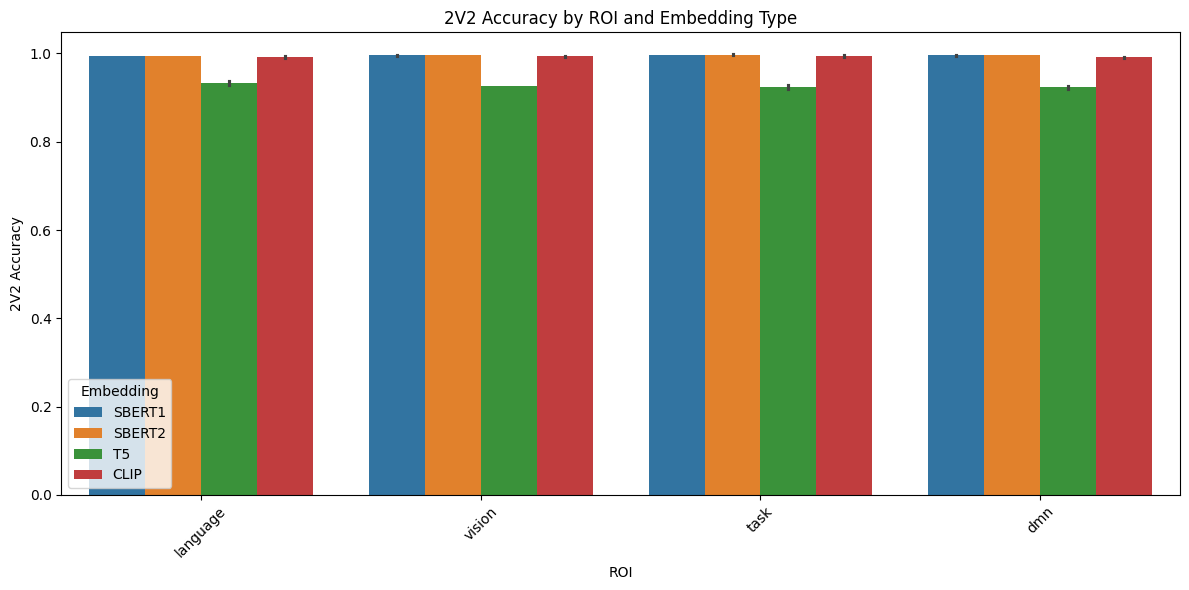

In [19]:
# 1. Single ROI decoder results
print("\n=== Visualizing Single ROI Decoder Results ===")

plt.figure(figsize=(12, 6))
sns.barplot(data=single_roi_df, x='ROI', y='2V2 Accuracy', hue='Embedding')
plt.title('2V2 Accuracy by ROI and Embedding Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('single_roi_2v2_accuracy.png')
plt.close()



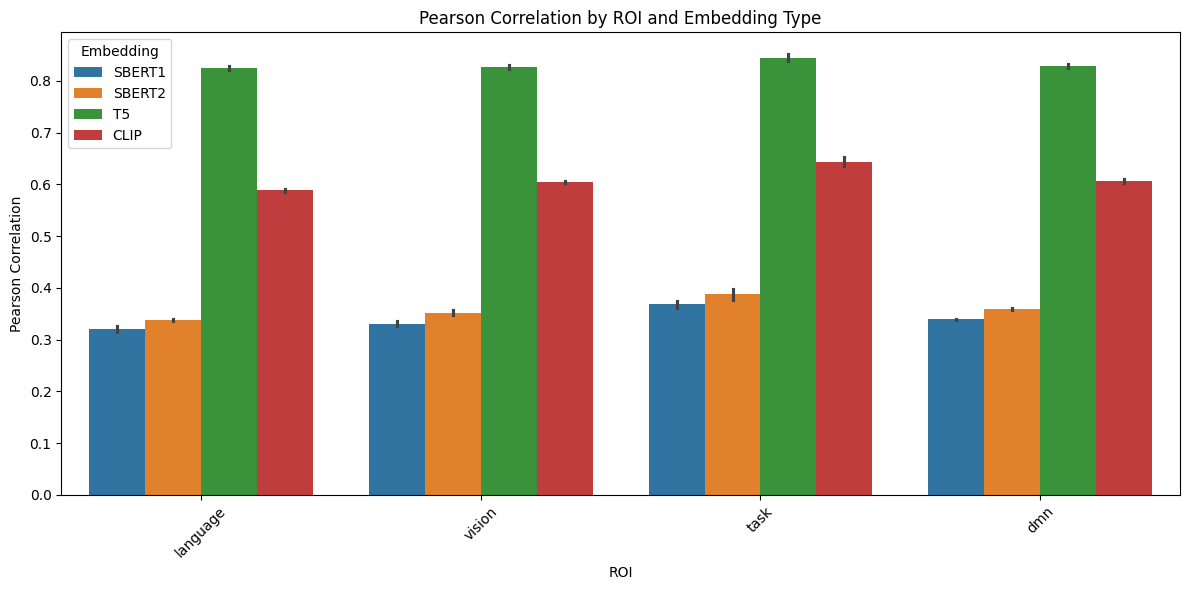

In [20]:

plt.figure(figsize=(12, 6))
sns.barplot(data=single_roi_df, x='ROI', y='Pearson Correlation', hue='Embedding')
plt.title('Pearson Correlation by ROI and Embedding Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('single_roi_pearson_correlation.png')
plt.close()



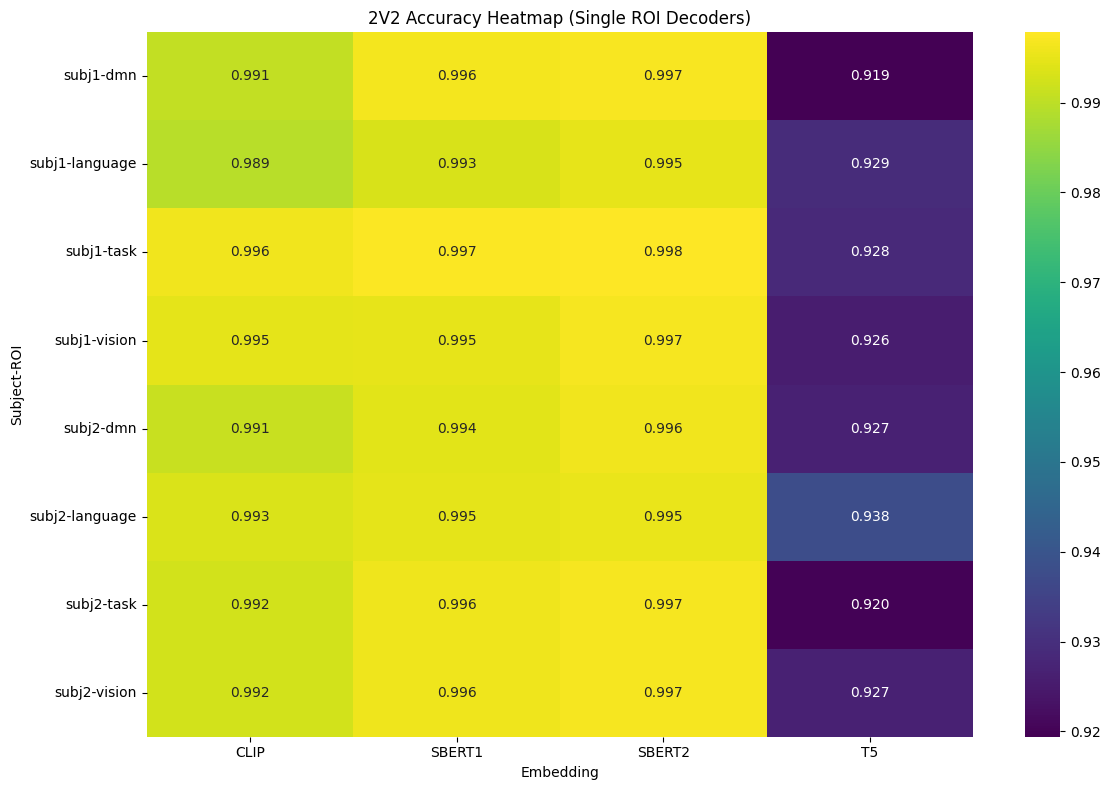

In [21]:
# Heatmap of 2V2 Accuracy
plt.figure(figsize=(12, 8))
pivot = single_roi_df.pivot_table(index=['Subject', 'ROI'], columns='Embedding', values='2V2 Accuracy')
sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.3f')
plt.title('2V2 Accuracy Heatmap (Single ROI Decoders)')
plt.tight_layout()
plt.show()
plt.savefig('single_roi_2v2_heatmap.png')
plt.close()


=== Visualizing Multi-ROI Decoder Results ===


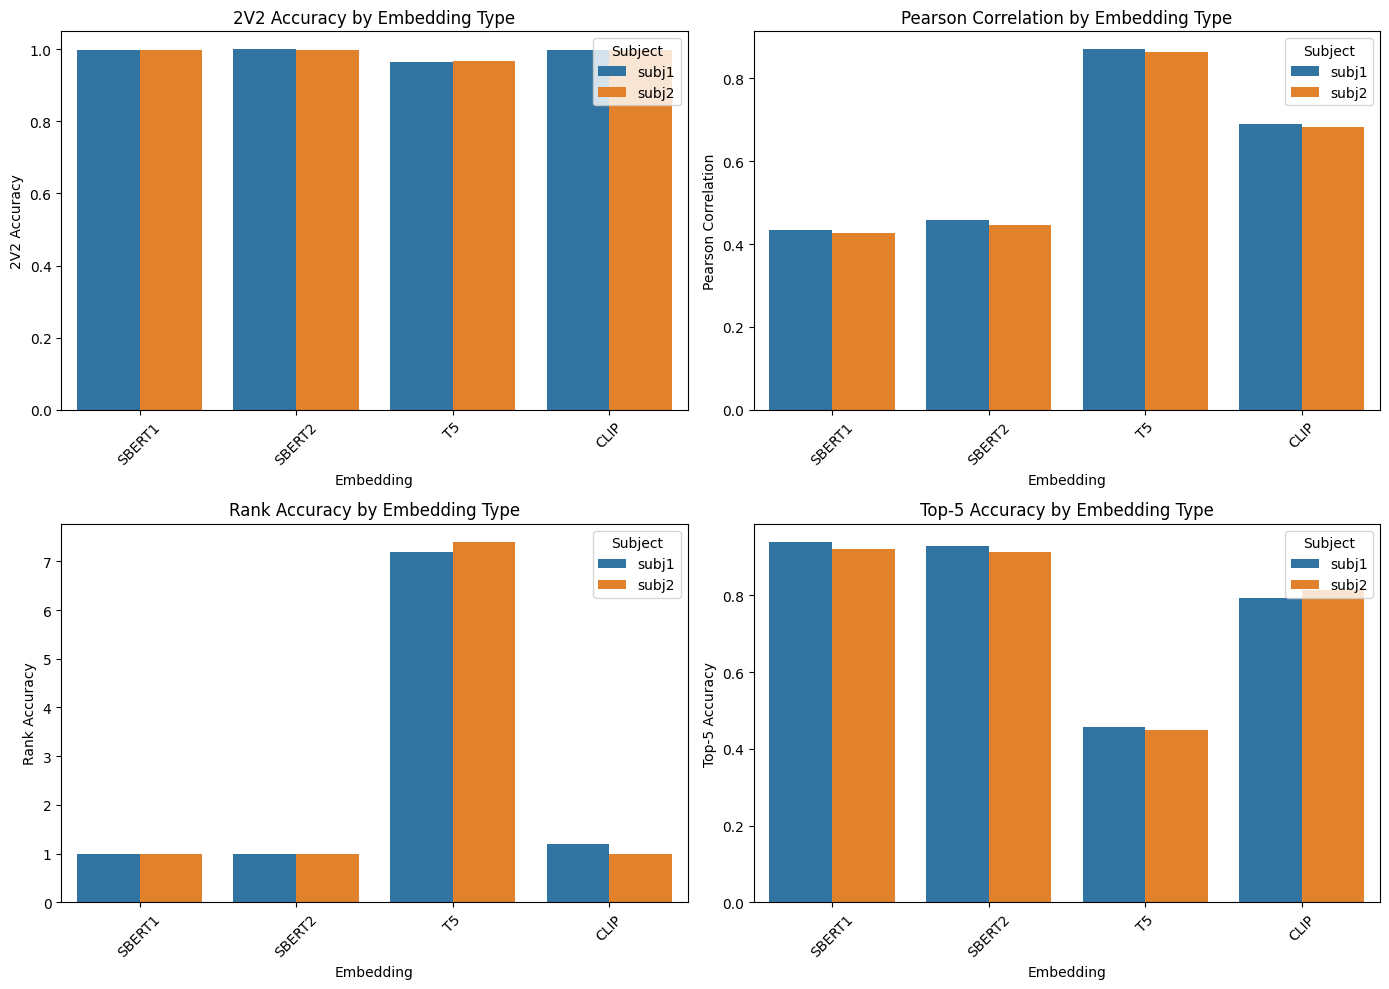

In [22]:

# 2. Multi-ROI decoder results
print("\n=== Visualizing Multi-ROI Decoder Results ===")

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.barplot(data=multi_roi_df, x='Embedding', y='2V2 Accuracy', hue='Subject')
plt.title('2V2 Accuracy by Embedding Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.barplot(data=multi_roi_df, x='Embedding', y='Pearson Correlation', hue='Subject')
plt.title('Pearson Correlation by Embedding Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.barplot(data=multi_roi_df, x='Embedding', y='Rank Accuracy', hue='Subject')
plt.title('Rank Accuracy by Embedding Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.barplot(data=multi_roi_df, x='Embedding', y='Top-5 Accuracy', hue='Subject')
plt.title('Top-5 Accuracy by Embedding Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
plt.savefig('multi_roi_metrics.png')
plt.close()


=== Comparing Single ROI vs Multi-ROI Performance ===


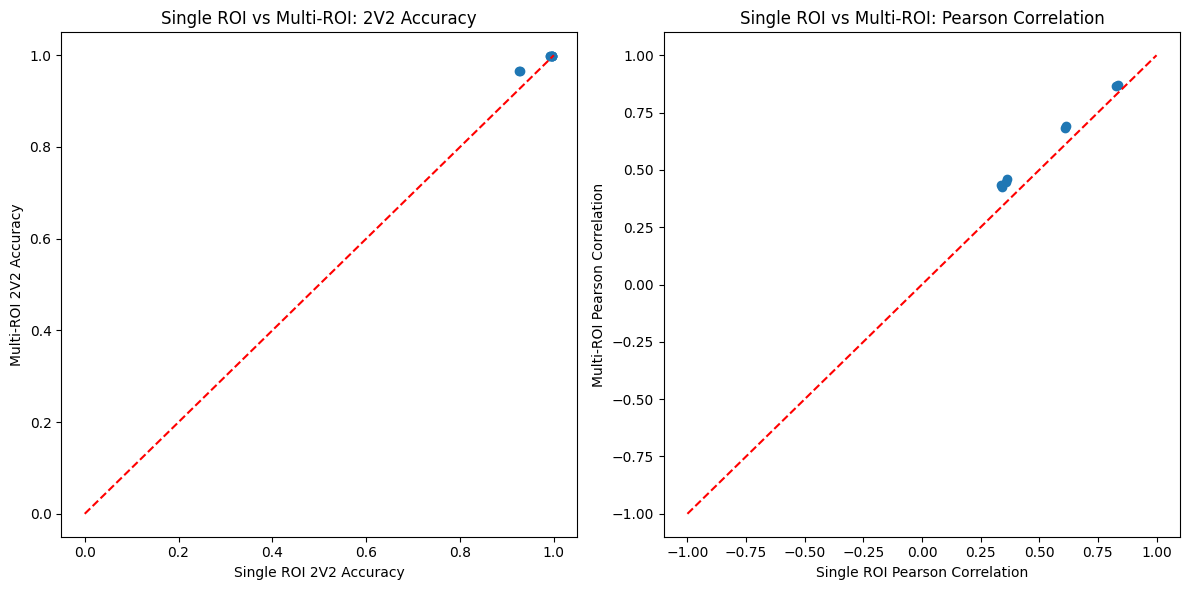

In [18]:
# Compare single ROI vs multi-ROI performance
print("\n=== Comparing Single ROI vs Multi-ROI Performance ===")

# Group single ROI results by subject and embedding
single_roi_group = single_roi_df.groupby(['Subject', 'Embedding']).agg({
    '2V2 Accuracy': 'mean',
    'Pearson Correlation': 'mean'
}).reset_index()

# Merge with multi-ROI results
comparison_df = pd.merge(
    single_roi_group, 
    multi_roi_df[['Subject', 'Embedding', '2V2 Accuracy', 'Pearson Correlation']],
    on=['Subject', 'Embedding'],
    suffixes=('_SingleROI', '_MultiROI')
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(comparison_df['2V2 Accuracy_SingleROI'], comparison_df['2V2 Accuracy_MultiROI'])
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Single ROI 2V2 Accuracy')
plt.ylabel('Multi-ROI 2V2 Accuracy')
plt.title('Single ROI vs Multi-ROI: 2V2 Accuracy')

plt.subplot(1, 2, 2)
plt.scatter(comparison_df['Pearson Correlation_SingleROI'], comparison_df['Pearson Correlation_MultiROI'])
plt.plot([-1, 1], [-1, 1], 'r--')
plt.xlabel('Single ROI Pearson Correlation')
plt.ylabel('Multi-ROI Pearson Correlation')
plt.title('Single ROI vs Multi-ROI: Pearson Correlation')

plt.tight_layout()
plt.show()
plt.savefig('single_vs_multi_roi.png')
plt.close()


In [16]:
# 5.3 Text recreation from predicted embeddings (Bonus)
print("\n=== Text Recreation from Predicted Embeddings (Bonus) ===")

def find_closest_sentences(pred_embedding, true_embeddings, stimuli_list, top_k=5):
    """
    Find the closest sentences to a predicted embedding.
    
    Args:
        pred_embedding: Predicted embedding
        true_embeddings: All true embeddings
        stimuli_list: List of sentences
        top_k: Number of closest sentences to return
        
    Returns:
        List of top-k closest sentences
    """
    # Compute similarities
    similarities = []
    for i, true_emb in enumerate(true_embeddings):
        similarity = cosine_similarity(pred_embedding.reshape(1, -1), true_emb.reshape(1, -1))[0][0]
        similarities.append((i, similarity))
    
    # Sort by similarity in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Return top-k sentences
    return [(stimuli_list[idx], sim) for idx, sim in similarities[:top_k]]

# Choose one example for demonstration
subject_name = 'subj1'
embedding_name = 'SBERT1'
embedding_data = embeddings[embedding_name]

# Train multi-ROI decoder
multi_roi_decoder = MultiROIDecoder(rois=ROIs)
multi_roi_decoder.fit(subjects[subject_name], embedding_data)

# Predict embeddings
pred_embeddings = multi_roi_decoder.predict(subjects[subject_name])

# Choose a few samples
sample_indices = [0, 100, 200, 300, 400]

print(f"Text Recreation Examples for {subject_name}, {embedding_name} Embeddings:")
for idx in sample_indices:
    true_sentence = stimuli[idx]
    pred_embedding = pred_embeddings[idx]
    
    closest_sentences = find_closest_sentences(pred_embedding, embedding_data, stimuli)
    
    print(f"\nOriginal Sentence: {true_sentence}")
    print("Top 5 Closest Sentences:")
    for i, (sentence, similarity) in enumerate(closest_sentences):
        print(f"{i+1}. (Similarity: {similarity:.4f}) {sentence}")

print("\nBrain Decoder implementation complete!")


=== Text Recreation from Predicted Embeddings (Bonus) ===
Text Recreation Examples for subj1, SBERT1 Embeddings:

Original Sentence: An accordion is a portable musical instrument with two keyboards.
Top 5 Closest Sentences:
1. (Similarity: 1.0000) An accordion is a portable musical instrument with two keyboards.
2. (Similarity: 0.7789) One accordion keyboard is used for individual notes, the other for chords.
3. (Similarity: 0.7306) An accordionist plays both keyboards while opening and closing the bellows.
4. (Similarity: 0.5817) Accordions produce sound with bellows that blow air through reeds.
5. (Similarity: 0.5671) The piano is a popular musical instrument played by means of a keyboard.

Original Sentence: Drunk driving is the act of driving under the effects of alcohol.
Top 5 Closest Sentences:
1. (Similarity: 1.0000) Drunk driving is the act of driving under the effects of alcohol.
2. (Similarity: 0.7091) Drunk driving of any vehicle is a crime in most of the world.
3. (Similar

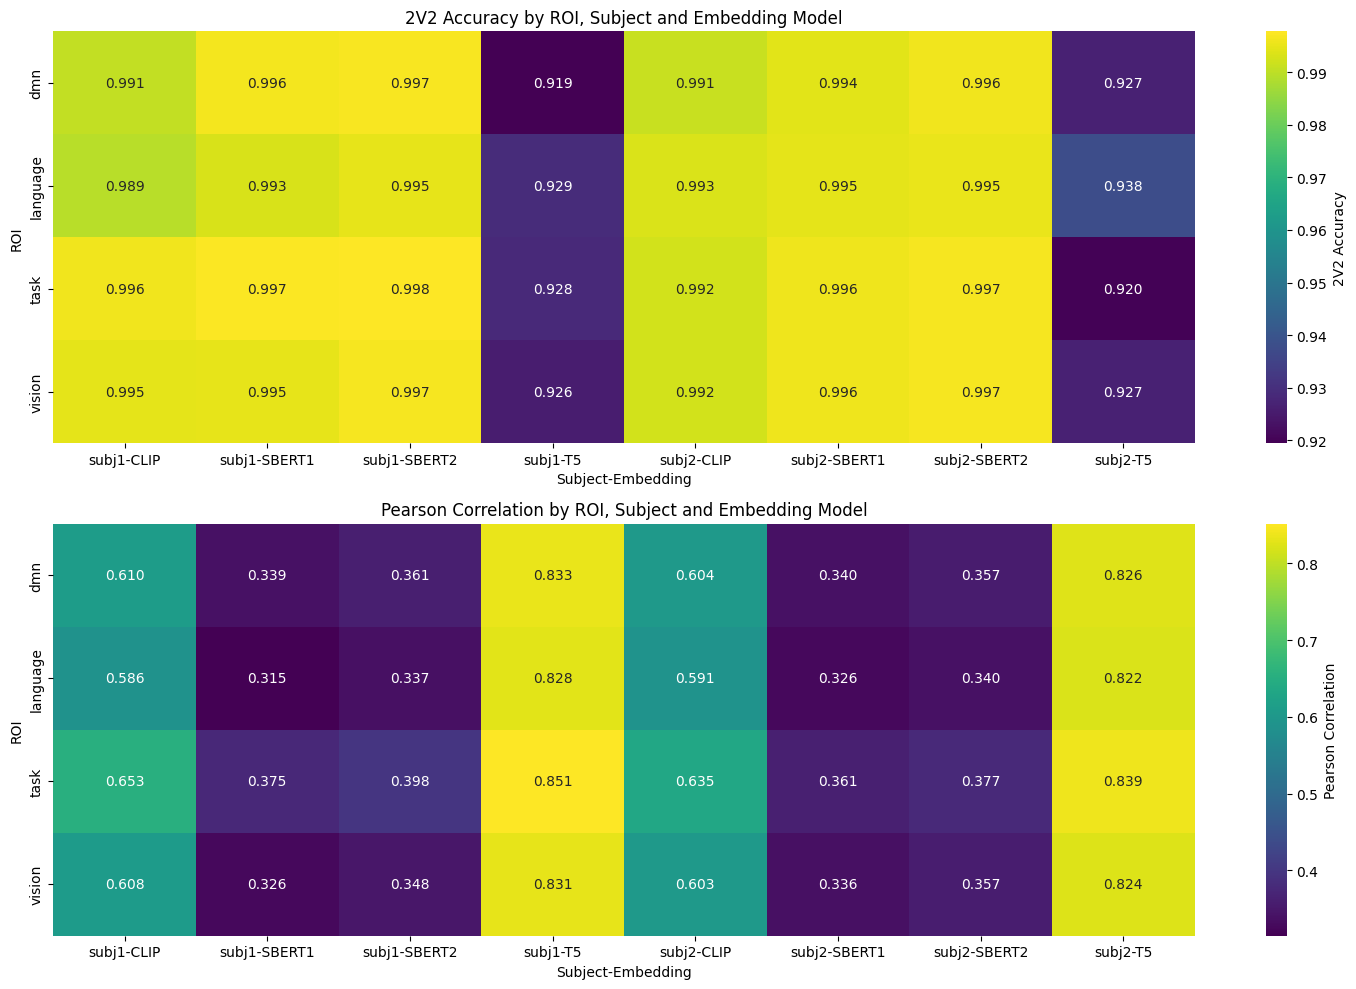

In [23]:
# Create more detailed heatmaps comparing all metrics
plt.figure(figsize=(15, 10))

# For 2V2 Accuracy
plt.subplot(2, 1, 1)
pivot = single_roi_df.pivot_table(index=['ROI'], columns=['Subject', 'Embedding'], values='2V2 Accuracy')
sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': '2V2 Accuracy'})
plt.title('2V2 Accuracy by ROI, Subject and Embedding Model')
plt.tight_layout()

# For Pearson Correlation
plt.subplot(2, 1, 2)
pivot = single_roi_df.pivot_table(index=['ROI'], columns=['Subject', 'Embedding'], values='Pearson Correlation')
sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'Pearson Correlation'})
plt.title('Pearson Correlation by ROI, Subject and Embedding Model')
plt.tight_layout()

plt.savefig('detailed_performance_heatmaps.png')
plt.show()